In [1]:
# loading libraries
from keras import Input, layers, models, optimizers, regularizers
from keras.initializers import glorot_uniform
from keras.layers import Activation, Add, AveragePooling2D, BatchNormalization, Conv2D, Dense, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D, ZeroPadding2D
from keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import tensorflow as tf

%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

데이터 불러오기

In [2]:
df=pd.read_pickle("./LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df = df.drop(['waferIndex'], axis = 1)

In [4]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)

In [5]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df = df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [6]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

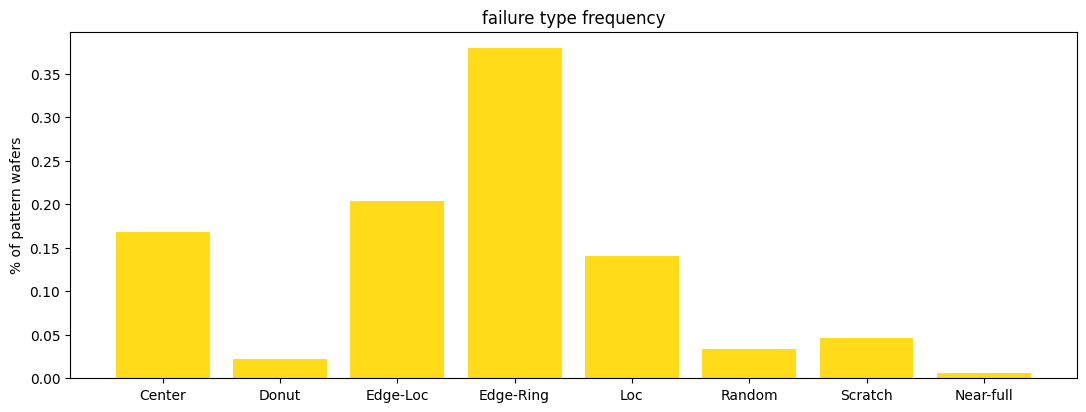

In [7]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 

ax2 = plt.subplot(gs[1])
tol_wafers = df.shape[0]
no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [8]:
sub_df = df.loc[df['waferMapDim'] == (25, 27)]

sw = np.ones((1, 25, 27))
label = list()

for i in range(len(sub_df)):
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 25, 27)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [9]:
x1 = sw[1:]
# 27 x 27 사이즈로 맞추기 위한 padding 처리
x = np.pad(x1, ((0,0),(1,1),(0,0)), mode='constant', constant_values = (0,0))
y = np.array(label).reshape((-1,1))

In [10]:
sub_df1 = df.loc[df['waferMapDim'] == (26, 26)]

sw1 = np.ones((1, 26, 26))
label1 = list()

for i in range(len(sub_df1)):
    if len(sub_df1.iloc[i,:]['failureType']) == 0:
        continue
    sw1 = np.concatenate((sw1, sub_df1.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label1.append(sub_df1.iloc[i,:]['failureType'][0][0])

In [11]:
x2 = sw1[1:]
x3 = np.pad(x2, ((0,0),(1,0),(1,0)), mode='constant', constant_values = (0,0))
y2 = np.array(label1).reshape((-1,1))

In [12]:
sub_df2 = df.loc[df['waferMapDim'] == (27, 25)]

sw2 = np.ones((1, 27, 25))
label2= list()

for i in range(len(sub_df2)):
    if len(sub_df2.iloc[i,:]['failureType']) == 0:
        continue
    sw2 = np.concatenate((sw2, sub_df2.iloc[i,:]['waferMap'].reshape(1, 27, 25)))
    label2.append(sub_df2.iloc[i,:]['failureType'][0][0])

In [13]:
x4 = sw2[1:]
x5 = np.pad(x4, ((0,0),(0,0),(1,1)), mode='constant', constant_values = (0,0))
y3 = np.array(label2).reshape((-1,1))

In [14]:
x3 = np.concatenate((x3, x5[0:]))
y2 = np.concatenate((y2, y3))

In [15]:
x = np.concatenate((x, x3[0:]))
y = np.concatenate((y, y2))

In [16]:
faulty_case = np.unique(y)

In [17]:
# '감지되지 않는' none 불량 라벨 제거
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=25000, replace=False)]
new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [18]:
#train과 test 데이터를 8:2 비율로 맞춤
x_train_temp, x_test, y_train_temp, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=789)

In [19]:
#x_test : 채널 추가
x_test = x_test.reshape((-1, 27, 27, 1))

In [20]:
# One-hot-Encoding 
nx_test = np.zeros((len(x_test), 27, 27, 3))

for w in range(len(x_test)):
    for i in range(27):
        for j in range(27):
            nx_test[w, i, j, int(x_test[w, i, j])] = 1

In [21]:
#y_test : 문자열 데이터를 정수형으로 형변환
for i, l in enumerate(faulty_case):
    y_test[y_test==l] = i
    
# one-hot-encoding - 10진 정수 형식을 2진 바이너리 형식으로 변경
y_test = to_categorical(y_test)

In [22]:
# One-hot-Encoding
nx_train = np.zeros((len(x_train_temp), 27, 27, 3))

for w in range(len(x_train_temp)):
    for i in range(27):
        for j in range(27):
            nx_train[w, i, j, int(x_train_temp[w, i, j])] = 1

Convolutional AutoEncoder

In [23]:
sx_train = np.delete(nx_train,(0,0,0,0), 1)

In [24]:
sx_train = np.delete(sx_train,(0,0,0,0), 2)

In [25]:
epoch = 50
batch_size=500

In [26]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D(padding='same')(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# decoder layers 연결
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

AutoEncoder = models.Model(input_tensor, output_tensor(decode))
AutoEncoder.compile(optimizer = 'Adam',
              loss = 'mse',
             ) 

In [27]:
AutoEncoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [28]:
with tf.device('/GPU:0'):
    AutoEncoder.fit(sx_train, sx_train, batch_size=batch_size, epochs=epoch, verbose=2)

Epoch 1/50
31/31 - 7s - loss: 0.1214 - 7s/epoch - 236ms/step
Epoch 2/50
31/31 - 0s - loss: 0.0762 - 486ms/epoch - 16ms/step
Epoch 3/50
31/31 - 0s - loss: 0.0602 - 492ms/epoch - 16ms/step
Epoch 4/50
31/31 - 0s - loss: 0.0496 - 481ms/epoch - 16ms/step
Epoch 5/50
31/31 - 0s - loss: 0.0397 - 478ms/epoch - 15ms/step
Epoch 6/50
31/31 - 1s - loss: 0.0324 - 500ms/epoch - 16ms/step
Epoch 7/50
31/31 - 0s - loss: 0.0274 - 476ms/epoch - 15ms/step
Epoch 8/50
31/31 - 0s - loss: 0.0238 - 483ms/epoch - 16ms/step
Epoch 9/50
31/31 - 0s - loss: 0.0211 - 488ms/epoch - 16ms/step
Epoch 10/50
31/31 - 0s - loss: 0.0189 - 493ms/epoch - 16ms/step
Epoch 11/50
31/31 - 0s - loss: 0.0171 - 479ms/epoch - 15ms/step
Epoch 12/50
31/31 - 0s - loss: 0.0156 - 485ms/epoch - 16ms/step
Epoch 13/50
31/31 - 0s - loss: 0.0143 - 476ms/epoch - 15ms/step
Epoch 14/50
31/31 - 0s - loss: 0.0132 - 481ms/epoch - 16ms/step
Epoch 15/50
31/31 - 0s - loss: 0.0123 - 488ms/epoch - 16ms/step
Epoch 16/50
31/31 - 1s - loss: 0.0114 - 501ms/epoch

In [29]:
encoder = models.Model(input_tensor, latent_vector)

In [30]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [31]:
encoded_x = encoder.predict(sx_train)

471/471 [==============================] - 1s 1ms/step


In [32]:
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

In [33]:
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)

471/471 [==============================] - 1s 2ms/step


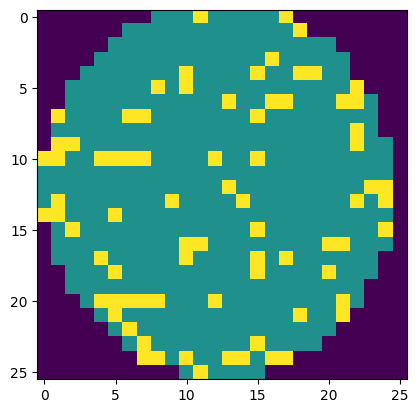

In [34]:
# check original faulty wafer data
plt.imshow(np.argmax(sx_train[3], axis=2))

471/471 [==============================] - 1s 2ms/step


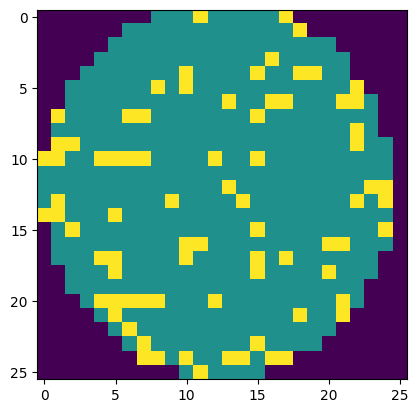

In [35]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

471/471 [==============================] - 1s 2ms/step


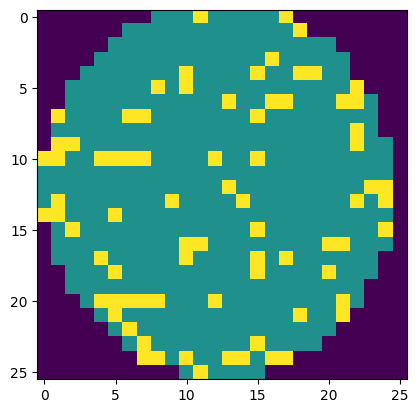

In [36]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(AutoEncoder.predict(sx_train), axis=3)
plt.imshow(gen_x[3])

In [37]:
sy_train_temp = np.array(y_train_temp)

In [38]:
# 웨이퍼 데이터 증강 수행
def gen_data(wafer, label):
    encoded_x = encoder.predict(wafer)
    
    # 노이즈 웨이퍼 수집 배열
    genn_x = np.zeros((1, 26, 26, 3))
    
    # 10000개의 증강 데이터 생성
    for i in range((10000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        genn_x = np.concatenate((genn_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(genn_x), 1), label)
    
    return genn_x[1:], gen_y[1:]

In [39]:
# 훈련 데이터셋 증강
for f in faulty_case : 
    if f == 'none': 
        continue
    genn_x, genn_y = gen_data(sx_train[np.where(y_train_temp==f)[0]], f)
    sx_train = np.concatenate((sx_train, genn_x), axis=0)
    sy_train_temp = np.concatenate((sy_train_temp, genn_y))

3/3 [==============================] - 0s 4ms/step


In [40]:
#new training dataset
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(sy_train_temp[sy_train_temp==f])))

Center : 13286
Donut : 10008
Edge-Loc : 10890
Edge-Ring : 10094
Loc : 10557
Near-full : 10064
Random : 10208
Scratch : 10164
none : 11809


In [41]:
nsx_train = np.pad(sx_train, ((0,0),(1,0),(1,0),(0,0)), mode='constant', constant_values = (0,0))

In [42]:
for i, l in enumerate(faulty_case):
    sy_train_temp[sy_train_temp==l] = i
    
# one-hot-encoding
y_train = to_categorical(sy_train_temp)

In [43]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [44]:
np.set_printoptions(precision=2)

In [45]:
def VGG16(include_top=True,  pooling=None, classes=9):
    
    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(input_tensor)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(1028, activation='relu', name='fc1')(x)
        x = layers.Dense(1028, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Create model.
    model = models.Model(input_tensor, x, name='vgg16') 

    return model

In [46]:
VGG_model = VGG16(include_top=True, pooling=None, classes=9)

In [47]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 27, 27, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 27, 27, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 27, 27, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 13, 13, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 13, 13, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 13, 13, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 6, 6, 128)         0     

In [48]:
VGG_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [49]:
with tf.device('/GPU:0'):
    VGG_model_fit = VGG_model.fit(nsx_train, y_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Epoch 1/50
108/108 [==============================] - 31s 214ms/step - loss: 1.9298 - accuracy: 0.2200 - val_loss: 1.0464 - val_accuracy: 0.8630
Epoch 2/50
108/108 [==============================] - 16s 151ms/step - loss: 0.8156 - accuracy: 0.6634 - val_loss: 0.5849 - val_accuracy: 0.8643
Epoch 3/50
108/108 [==============================] - 16s 147ms/step - loss: 0.2135 - accuracy: 0.9218 - val_loss: 0.1818 - val_accuracy: 0.9565
Epoch 4/50
108/108 [==============================] - 16s 146ms/step - loss: 0.0595 - accuracy: 0.9821 - val_loss: 0.4822 - val_accuracy: 0.8415
Epoch 5/50
108/108 [==============================] - 16s 147ms/step - loss: 0.0469 - accuracy: 0.9864 - val_loss: 0.1704 - val_accuracy: 0.9673
Epoch 6/50
108/108 [==============================] - 16s 147ms/step - loss: 0.0142 - accuracy: 0.9961 - val_loss: 0.1647 - val_accuracy: 0.9679
Epoch 7/50
108/108 [==============================] - 16s 146ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 0.1883 - val_ac

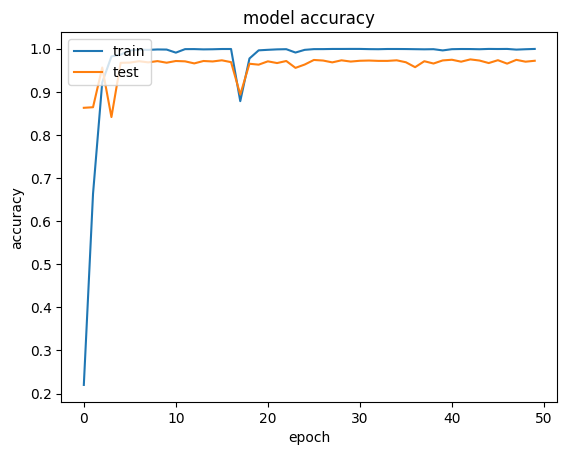

In [50]:
# accuracy plot 
plt.plot(VGG_model_fit.history['accuracy'])
plt.plot(VGG_model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

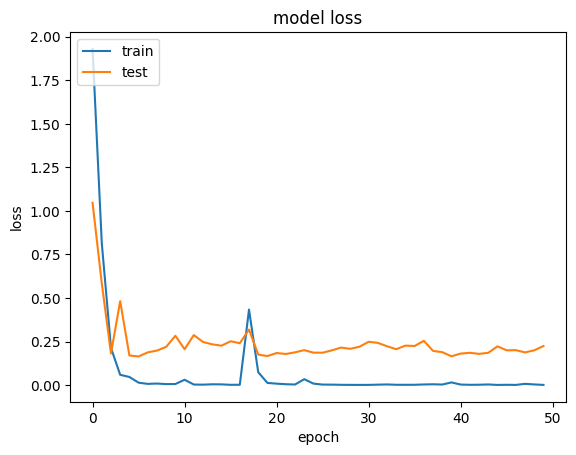

In [51]:
# loss plot
plt.plot(VGG_model_fit.history['loss'])
plt.plot(VGG_model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
vy_pred = VGG_model.predict(nx_test)

118/118 [==============================] - 1s 6ms/step


In [54]:
vy_test_decode = np.ones(len(y_test))
vy_pred_decode = np.ones(len(vy_pred))

for i in range(len(vy_pred)):
    vy_pred_decode[i] = np.argmax(vy_pred[i])
    vy_test_decode[i] = np.argmax(y_test[i])

In [55]:
vmis_index = np.where(vy_pred_decode != vy_test_decode)

In [56]:
print(classification_report(vy_test_decode, vy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.98      0.98      0.98       466
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.83      0.81      0.82       142
   Edge-Ring       1.00      0.71      0.83         7
         Loc       0.84      0.71      0.77       114
   Near-full       1.00      1.00      1.00        11
      Random       0.89      0.81      0.85        21
     Scratch       0.64      0.39      0.48        18
        none       0.98      0.99      0.99      2986

    accuracy                           0.97      3766
   macro avg       0.80      0.71      0.75      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 458    0    1    0    0    0    0    0    7]
 [   1    0    0    0    0    0    0    0    0]
 [   0    0  115    0   11    0    1    0   15]
 [   0    0    2    5    0    0    0    0    0]
 [   3    1    9    0   81    0    1    1   18]
 [   0    0    0    0    0   11    0    0    0]
 [   0    0    2    0    0    0   17    1    1]
 [   1    0    0    0    2    0    0    7    8]
 [   5    0   10    0    2    0    0    2 2967]]
Normalized confusion matrix
[[9.83e-01 0.00e+00 2.15e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.50e-02]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [0.00e+00 0.00e+00 8.10e-01 0.00e+00 7.75e-02 0.00e+00 7.04e-03 0.00e+00
  1.06e-01]
 [0.00e+00 0.00e+00 2.86e-01 7.14e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [2.63e-02 8.77e-03 7.89e-02 0.00e+00 7.11e-01 0.00e+00 8.77e-03 8.77e-03
  1.58e-01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00

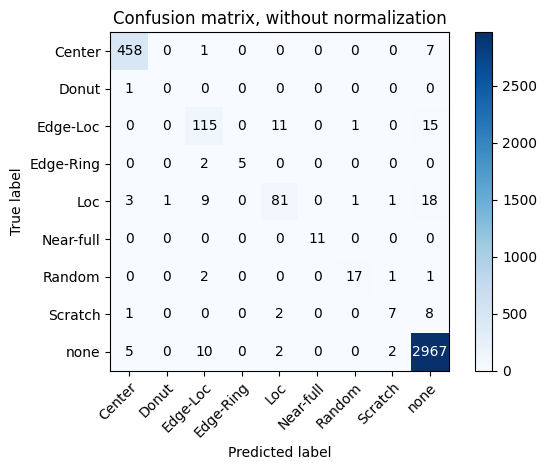

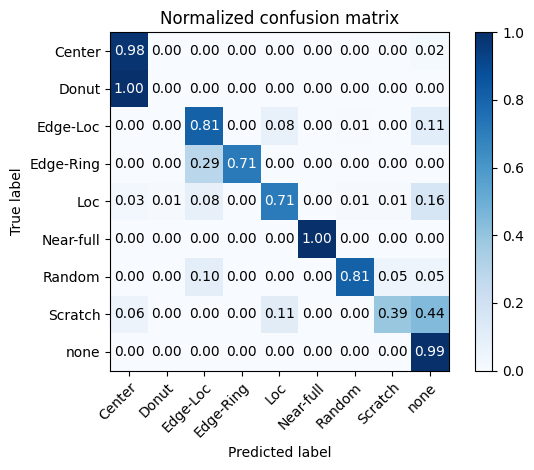

In [57]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(vy_test_decode, vy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(vy_test_decode, vy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [58]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [59]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [60]:
def ResNet50(input_shape = (27, 27, 3), classes = 9):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # input_shpae 27 x 27 x 3
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # ResidualBlock 1
    X = Conv2D(64, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)

    # ResidualBlock 2 (≈3 layers)
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32,32,128], stage=2, block='b')
    X = identity_block(X, 3, [32,32,128], stage=2, block='c')
    
    # ResidualBlock 3 (≈4 layers)
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # ResidualBlock 4 (≈6 layers)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # ResidualBlock 5 (≈3 layers)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name = "avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = models.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [61]:
Rmodel = ResNet50(input_shape = (27, 27, 3), classes = 9)

In [62]:
Rmodel.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 29, 29, 3)   0           ['input_4[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 27, 27, 64)   1792        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 27, 27, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [63]:
Rmodel.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
Resnet_fit = Rmodel.fit(nsx_train, y_train, epochs=30, validation_data=[nx_test, y_test], batch_size = 700, shuffle=True)

Epoch 1/30
139/139 [==============================] - 36s 195ms/step - loss: 0.2547 - accuracy: 0.9128 - val_loss: 1.2043 - val_accuracy: 0.7929
Epoch 2/30
139/139 [==============================] - 23s 168ms/step - loss: 0.0257 - accuracy: 0.9922 - val_loss: 7.1309 - val_accuracy: 0.0385
Epoch 3/30
139/139 [==============================] - 23s 165ms/step - loss: 0.0111 - accuracy: 0.9966 - val_loss: 11.0351 - val_accuracy: 0.0791
Epoch 4/30
139/139 [==============================] - 23s 164ms/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 1.0225 - val_accuracy: 0.7780
Epoch 5/30
139/139 [==============================] - 23s 164ms/step - loss: 0.0164 - accuracy: 0.9952 - val_loss: 0.2990 - val_accuracy: 0.9588
Epoch 6/30
139/139 [==============================] - 23s 164ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.3204 - val_accuracy: 0.9559
Epoch 7/30
139/139 [==============================] - 23s 167ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.4236 - val_a

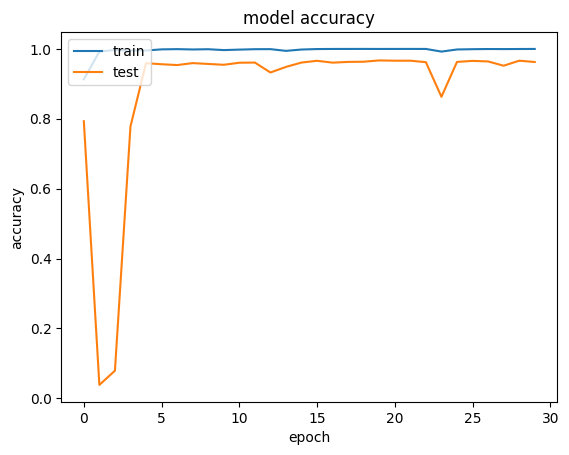

In [65]:
# accuracy plot 
plt.plot(Resnet_fit.history['accuracy'])
plt.plot(Resnet_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

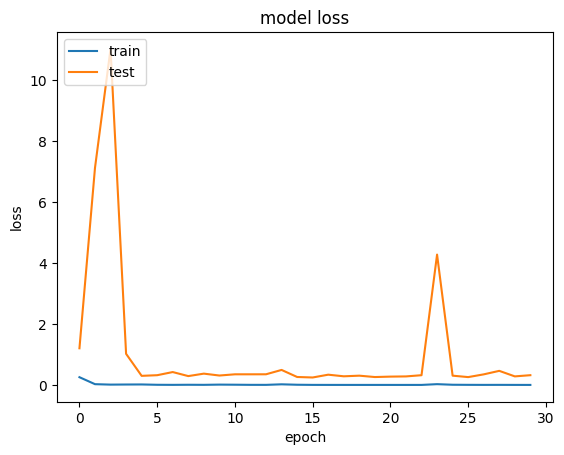

In [66]:
# loss plot
plt.plot(Resnet_fit.history['loss'])
plt.plot(Resnet_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
resy_pred = Rmodel.predict(nx_test)

118/118 [==============================] - 3s 13ms/step


In [68]:
resy_test_decode = np.ones(len(y_test))
resy_pred_decode = np.ones(len(resy_pred))

for i in range(len(resy_pred)):
    resy_pred_decode[i] = np.argmax(resy_pred[i])
    resy_test_decode[i] = np.argmax(y_test[i])

In [69]:
resmis_index = np.where(resy_pred_decode != resy_test_decode)

In [70]:
print(classification_report(resy_test_decode, resy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.99      0.97      0.98       466
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.84      0.74      0.79       142
   Edge-Ring       1.00      0.57      0.73         7
         Loc       0.88      0.45      0.59       114
   Near-full       1.00      0.82      0.90        11
      Random       0.89      0.76      0.82        21
     Scratch       1.00      0.11      0.20        18
        none       0.97      1.00      0.98      2986

    accuracy                           0.96      3766
   macro avg       0.84      0.60      0.67      3766
weighted avg       0.96      0.96      0.96      3766



Confusion matrix, without normalization
[[ 452    0    1    0    0    0    0    0   13]
 [   0    0    0    0    1    0    0    0    0]
 [   0    0  105    0    5    0    0    0   32]
 [   0    0    1    4    0    0    0    0    2]
 [   6    0   12    0   51    0    2    0   43]
 [   0    0    2    0    0    9    0    0    0]
 [   0    0    4    0    0    0   16    0    1]
 [   0    0    0    0    0    0    0    2   16]
 [   0    0    0    0    1    0    0    0 2985]]
Normalized confusion matrix
[[9.70e-01 0.00e+00 2.15e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  2.79e-02]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [0.00e+00 0.00e+00 7.39e-01 0.00e+00 3.52e-02 0.00e+00 0.00e+00 0.00e+00
  2.25e-01]
 [0.00e+00 0.00e+00 1.43e-01 5.71e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  2.86e-01]
 [5.26e-02 0.00e+00 1.05e-01 0.00e+00 4.47e-01 0.00e+00 1.75e-02 0.00e+00
  3.77e-01]
 [0.00e+00 0.00e+00 1.82e-01 0.00e+00 0.00e+00 8.18e-01 0.00e+00 0.00

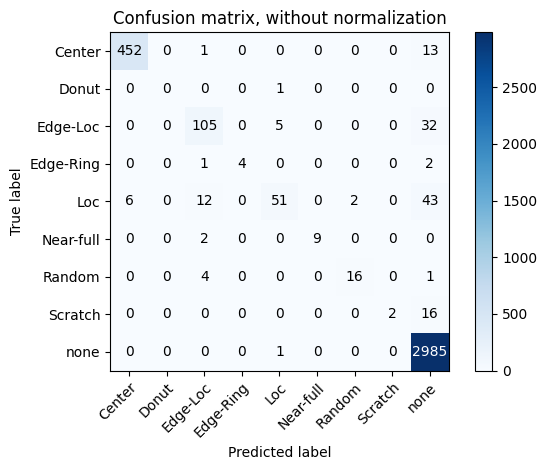

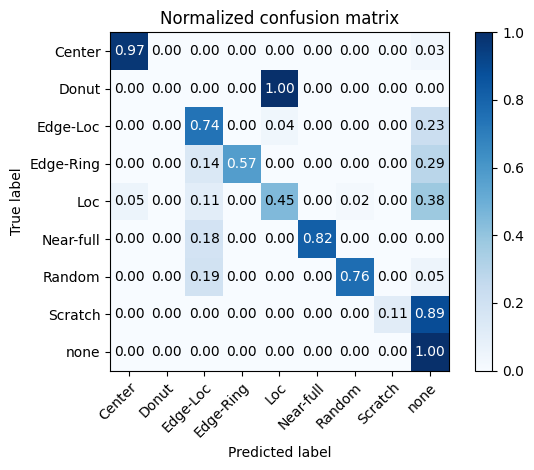

In [71]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(resy_test_decode, resy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(resy_test_decode, resy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [72]:
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'strides', 'se_ratio'
])

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(3, 1, 32, 16, 1, [1, 1], 0.25),
    BlockArgs(3, 2, 16, 24, 6, [2, 2], 0.25),
    BlockArgs(5, 2, 24, 40, 6, [2, 2], 0.25),
    BlockArgs(3, 3, 40, 80, 6, [2, 2], 0.25),
    BlockArgs(5, 3, 80, 112,6, [1, 1], 0.25),
    BlockArgs(5, 4, 112, 192, 6, [2, 2], 0.25),
    BlockArgs(3, 1, 192, 320, 6, [1, 1], 0.25)
]

CONV_KERNEL_INITIALIZER = glorot_uniform(seed=0)

BN_AXIS = 3

In [73]:
def get_swish():
    def swish(x):
        return x * tf.nn.sigmoid(x)
    return swish

In [74]:
def get_dropout():
    """Wrapper over custom dropout. Fix problem of ``None`` shape for tf.keras.
    It is not possible to define FixedDropout class as global object,
    because we do not have modules for inheritance at first time.

    Issue:
        https://github.com/tensorflow/tensorflow/issues/30946
    """

    class FixedDropout(layers.Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = tf.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    return FixedDropout

In [75]:
def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

In [76]:
def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

In [77]:
def MBConvBlock(inputs, block_args, activation, drop_rate=None, prefix='', ):
    """
    Mobile Inverted Residual Bottleneck Block
    """
    
    # workaround over non working dropout with None in noise_shape 
    Dropout = get_dropout()
    
    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
    x = inputs
    
    # Expansion phase
    output = block_args.input_filters * block_args.expand_ratio
    if block_args.expand_ratio != 1:
        x = layers.Conv2D(output, 1,
                          padding='same',
                          use_bias=False, 
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'expand_conv')(x)
        x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'expand_bn')(x)
        x = layers.Activation(activation, name=prefix + 'expand_activation')(x)
    
    # Depthwise convolution phase 
    x = layers.DepthwiseConv2D(block_args.kernel_size, 
                               strides=block_args.strides, 
                               padding='same',
                               use_bias=False, 
                               depthwise_initializer=CONV_KERNEL_INITIALIZER,
                               name=prefix + 'conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'bn')(x)
    x = layers.Activation(activation, name=prefix + 'activation')(x)
   
    # Squeeze and Excitation layer, if desired
    if has_se:
        num_sqeezed_channels = max(1, int(block_args.input_filters * block_args.se_ratio))
        
        se_tensor = layers.GlobalAveragePooling2D()(x)
        se_tensor = layers.Reshape((1,1,output), name=prefix + 'se_reshape')(se_tensor)
        se_tensor = layers.Conv2D(num_sqeezed_channels, 1, 
                          activation=activation, 
                          padding='same',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'se_reduce')(se_tensor)
        se_tensor = layers.Conv2D(output, 1, 
                          activation='sigmoid', 
                          padding='same',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'se_expand')(se_tensor)
        x = layers.multiply([x, se_tensor], name=prefix + 'se_excite')
    
    #Output phase
    x = layers.Conv2D(block_args.output_filters, 1,
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name=prefix + 'project_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'project_bn')(x)
    if all(s == 1 for s in block_args.strides) and block_args.input_filters == block_args.output_filters:
        if drop_rate and (drop_rate > 0):
            x = Dropout(drop_rate,
                        noise_shape=(None, 1, 1, 1),
                        name=prefix + 'drop')(x)
        x = layers.add([x, inputs], name=prefix + 'add')
    
    return x

In [78]:
def EfficientNet(width_coefficient,
                 depth_coefficient,
                 drop_connect_rate, 
                 input_shape,
                 classes,
                 dropout_rate=0.2,
                 depth_divisor=8,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 model_name='efficientnet'):
    
    input_tensor = layers.Input(input_shape)
    activation = get_swish()
    
    # Stem
    x = input_tensor
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2,2), 
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='stem_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name='stem_bn')(x)
    x = layers.Activation(activation, name='stem_activation')(x)
    
    # Build blocks
    num_blocks_total = sum(round_repeats(block_args.num_repeat, depth_coefficient) for block_args in blocks_args)
    block_num = 0
    
    for idx, block_args in enumerate(blocks_args):
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters, width_coefficient, depth_divisor),
            output_filters=round_filters(block_args.output_filters, width_coefficient, depth_divisor),
            num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))
        
        # The first block needs to take care of stride and filter size increase.
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        
        x = MBConvBlock(x, block_args,
                        activation=activation, 
                        drop_rate=drop_rate, 
                        prefix='block{}a_'.format(idx + 1))    
        block_num += 1
        
        if block_args.num_repeat > 1:
            block_args = block_args._replace(input_filters=block_args.output_filters, strides=[1, 1])
            for bidx in range(block_args.num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                block_prefix = 'block{}{}_'.format(idx + 1, string.ascii_lowercase[bidx + 1])
                
                x = MBConvBlock(x, block_args,
                                activation=activation, 
                                drop_rate=drop_rate, 
                                prefix=block_prefix)
                block_num += 1
                
    # Build top
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='top_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name='top_bn')(x)
    x = layers.Activation(activation, name='top_activation')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dropout(dropout_rate, name='top_dropout')(x)
    x = layers.Dense(classes, 
                     activation='softmax', 
                     kernel_initializer=CONV_KERNEL_INITIALIZER,
                     name='probs')(x)
    
    # 모델 생성
    model = models.Model(input_tensor, x, name=model_name)
    
    return model

In [79]:
Emodel = EfficientNet(1.0, 1.0, 0.2, input_shape = (27, 27, 3), classes=9, model_name='efficientnet-b0')

In [80]:
Emodel.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 14, 14, 32)   864         ['input_5[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 14, 14, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 14, 14, 32)   0           ['stem_bn[0][0]']                
                                                                                    

In [81]:
Emodel.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
with tf.device('/GPU:0'):
    Emodel_fit = Emodel.fit(nsx_train, y_train, epochs=30, validation_data=[nx_test, y_test], batch_size = 700, shuffle=True)

Epoch 1/30
139/139 [==============================] - 71s 413ms/step - loss: 0.3060 - accuracy: 0.8911 - val_loss: 2.2201 - val_accuracy: 0.0377
Epoch 2/30
139/139 [==============================] - 52s 377ms/step - loss: 0.0355 - accuracy: 0.9890 - val_loss: 2.2804 - val_accuracy: 0.0056
Epoch 3/30
139/139 [==============================] - 53s 378ms/step - loss: 0.0220 - accuracy: 0.9935 - val_loss: 2.3131 - val_accuracy: 0.0377
Epoch 4/30
139/139 [==============================] - 53s 380ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 2.1893 - val_accuracy: 0.0563
Epoch 5/30
139/139 [==============================] - 52s 374ms/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.2217 - val_accuracy: 0.9400
Epoch 6/30
139/139 [==============================] - 52s 376ms/step - loss: 0.0150 - accuracy: 0.9953 - val_loss: 0.5013 - val_accuracy: 0.8925
Epoch 7/30
139/139 [==============================] - 52s 378ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.7205 - val_ac

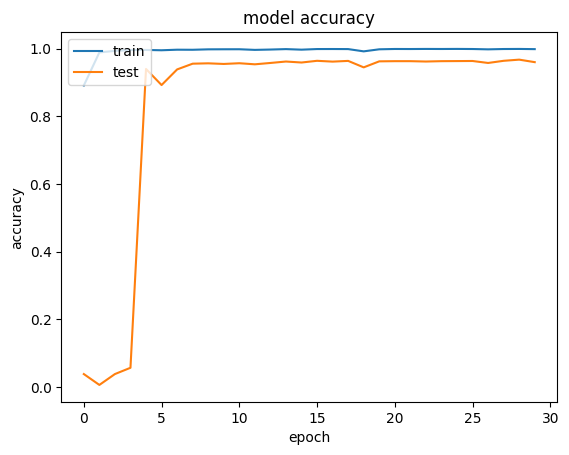

In [83]:
# accuracy plot 
plt.plot(Emodel_fit.history['accuracy'])
plt.plot(Emodel_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

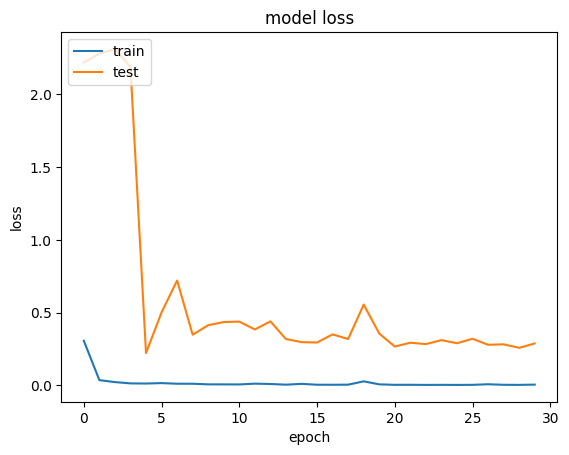

In [84]:
# loss plot
plt.plot(Emodel_fit.history['loss'])
plt.plot(Emodel_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [85]:
effy_pred = Emodel.predict(nx_test)

118/118 [==============================] - 4s 19ms/step


In [86]:
effy_test_decode = np.ones(len(y_test))
effy_pred_decode = np.ones(len(effy_pred))

for i in range(len(resy_pred)):
    effy_pred_decode[i] = np.argmax(effy_pred[i])
    effy_test_decode[i] = np.argmax(y_test[i])

In [87]:
effmis_index = np.where(effy_pred_decode != effy_test_decode)

In [88]:
print(classification_report(effy_test_decode, effy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.94      0.98      0.96       466
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.78      0.80      0.79       142
   Edge-Ring       0.75      0.43      0.55         7
         Loc       0.76      0.59      0.66       114
   Near-full       0.90      0.82      0.86        11
      Random       1.00      0.67      0.80        21
     Scratch       0.44      0.39      0.41        18
        none       0.98      0.99      0.98      2986

    accuracy                           0.96      3766
   macro avg       0.73      0.63      0.67      3766
weighted avg       0.96      0.96      0.96      3766



Confusion matrix, without normalization
[[ 457    0    0    0    2    0    0    0    7]
 [   0    0    0    0    1    0    0    0    0]
 [   1    0  113    1    5    0    0    1   21]
 [   0    0    4    3    0    0    0    0    0]
 [   8    0   17    0   67    0    0    2   20]
 [   0    0    2    0    0    9    0    0    0]
 [   0    0    1    0    3    1   14    1    1]
 [   0    0    0    0    1    0    0    7   10]
 [  18    0    8    0    9    0    0    5 2946]]
Normalized confusion matrix
[[0.98 0.   0.   0.   0.   0.   0.   0.   0.02]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.01 0.   0.8  0.01 0.04 0.   0.   0.01 0.15]
 [0.   0.   0.57 0.43 0.   0.   0.   0.   0.  ]
 [0.07 0.   0.15 0.   0.59 0.   0.   0.02 0.18]
 [0.   0.   0.18 0.   0.   0.82 0.   0.   0.  ]
 [0.   0.   0.05 0.   0.14 0.05 0.67 0.05 0.05]
 [0.   0.   0.   0.   0.06 0.   0.   0.39 0.56]
 [0.01 0.   0.   0.   0.   0.   0.   0.   0.99]]


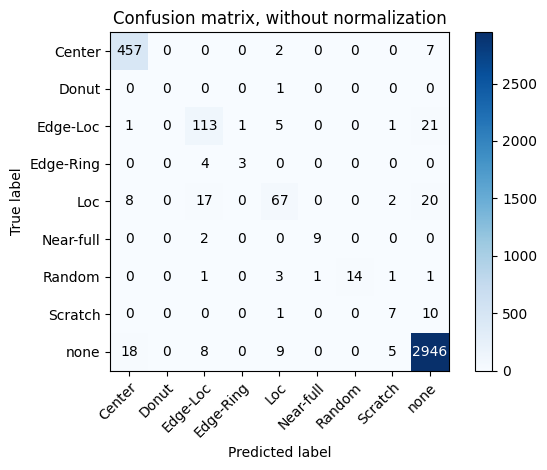

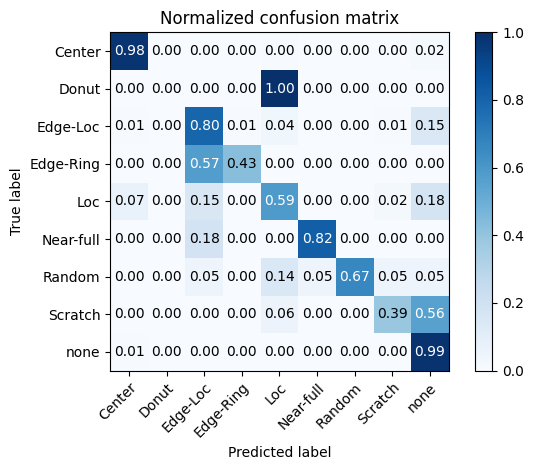

In [89]:
plot_confusion_matrix(effy_test_decode, effy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

plot_confusion_matrix(effy_test_decode, effy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()